In [1]:
import cv2
import numpy as np 
import random
import glob
import torch 
import matplotlib.pyplot as plt 
from matplotlib import colors
import matplotlib as mpl 
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
%matplotlib inline


In [2]:
def read_img(filepath):
	img = cv2.imread(filepath,0)
	return img 
def show_img(img):
# 	cv2.imshow('image',img)
# 	cv2.waitKey(0)
# 	cv2.destroyAllWindows()
    plt.imshow(img)

In [3]:
test_path = "/home/zhaocheng/Research/DeepOpticsV2/GeomData/GeomData/1.png"

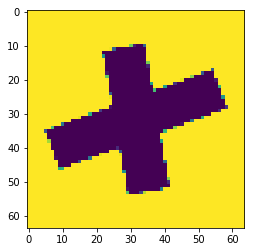

In [6]:
img = read_img(test_path)
show_img(img)
# print(img)

In [145]:
class DataLoader():
    def __init__(self, file_path, mode='all_file'):
        # a dataloader that reads all data into RAM for best performance
        # only valid for small dataset
        
        self.file_path = file_path
        self.mode = mode
        
        # build blobs first
        self.data_names, _, self.data_names_with_extenstion = self._get_all_names(self.file_path)
        
        if self.mode == 'all_file':
            self.blobs = self._build_blobs(self.file_path)
        else:
            raise NotImplementedError
        
        
    def dataloader(self, batchsize, repeatition=-1, transform=True,):
        # iterator to yeild data as needed 
        # 
        blobs_to_use = []
        
        while repeatition:
            random.shuffle(self.blobs)
            blobs_to_use.extend(self.blobs)
            len_blobs = len(blobs_to_use)
            
            for i in range(len_blobs // batchsize):
                # build data format as needed here.
                outdata = []
                
                for j in range(batchsize):
                    blob = blobs_to_use[i * batchsize + j]
#                     print(blob)
                    pattern = blob['pattern']
                    
                    # shift images, disable when training the autoencoder
#                     pattern, _ = self.shift_img(pattern, fx=1, fy=1, random=True)
                    
                    # rotate images
                    rot_angles = [0, 90, 180, 270]
                    angle = np.random.choice(rot_angles)
                    pattern, _ = self.rotate_img(pattern, angle, random=False)
                    
                    # flip images
                    pattern, _ = self.flip_img(pattern, random=True)
                    
                    # append to output datalist
                    outdata.append(pattern)
                    outdata_np = np.array(outdata)
                print(np.array(outdata).shape)
#                 outdata_ts = torch.FloatTensor(outdata)
                outdata_ts = torch.from_numpy(outdata_np)
                
                    # add extra 1 dim at output for this is gray scale imgs
                yield outdata_ts.unsqueeze(1)
            
            res_num = (len_blobs % (len_blobs // batchsize))
            
            if res_num == 0:
                blobs_to_use = []
            else:
                blobs_to_use = blobs_to_use[-(len_blobs % (len_blobs // batchsize)):]
            
            repeatition -= 1
    
    def get_blobs(self):
        
        return self.blobs
        
        
    def _build_blob(self, data_dir, data_name=None):
        # util functions to build blob of data
        # should be defined as desired
        # the blob is a dict with keys such as 
        #     'name', 'img_data', 'label', and additional requirement
        # 'name' is not a must but in current task it is better to adopt
        
        if data_name != None:
            img_path = data_dir + '/' + data_name + '.png'
        else:
            img_path = data_dir
        img = self._read_img(img_path)
        
        # construct blob
        blob = {}
        blob['name'] = data_name
        blob['pattern'] = img
        
        return blob
    
    def _build_blobs(self, data_dir):
        # build blobs of all data in the directory, ensenbled in a list
        # [blob1, blob2, blob3 ...]
        # should be defined as desired 
        
        file_names = self._get_all_names(data_dir)[0]
        
        blobs = []
        for name in file_names:
            blobs.append(self._build_blob(data_dir, name))
        
        return blobs
        
        
    def _get_all_names(self, directory, extension='.png'):
        # get all file names in the directory
        
        file_paths = glob.glob(directory + '/*' + extension)
        file_names = [item[len(directory)+1:-len(extension)] for item in file_paths]
        file_names_with_extension = [item[len(directory)+1:] for item in file_paths]
        
        return file_names, file_paths, file_names_with_extension
        
        
    def _read_img(self, img_path, mode='grayscale'):
        # return the img as numpy array
        
        if mode=='grayscale':
            img = cv2.imread(img_path, 0)
        else:
            # RGB mode
            img = cv2.imread(img_path)
        return img
    
    def _show_img(self, img):
        plt.imshow(img)
    
    
    
    def shift_img(self, img, fx=0.5, fy=0.5, random=True):
        # shift images with periodic boundary condition (with max fx and fy defined as args if random==True)
        # ONLY for grayscaled images]
        
        if random == True:
            fx, fy = np.random.uniform(0, 1) * fx, np.random.uniform(0, 1) * fy

        size = img.shape[0]
        sx, sy = int(size*fx), int(size*fy)

        canvas = -1 * np.ones(shape=(64,64))

        # shift x direction first
        i1 = img[:sx,:sy]
        i2 = img[sx:,:sy]
        i3 = img[:sx,sy:]
        i4 = img[sx:,sy:]

        canvas[:(size-sx),:(size-sy)] = i4
        canvas[:(size-sx),(size-sy):] = i2
        canvas[(size-sx):,(size-sy):] = i1
        canvas[(size-sx):,:(size-sy)] = i3
        
        return canvas, (sx, sy)
    
    def rotate_img(self, img, angle, random=False):
        # rotate images WITHOUT periodic boundary condition (with max angle defined as arg if random==True)
        # need further revision to adapt period boundary condition or have judgement on special cases
        
        if angle < 0:
            raise ValueError("Angle should be greater than 0!!!")
        
        if random:
            angle = np.random.uniform(0, angle)
        
        rows, cols = img.shape
        M = cv2.getRotationMatrix2D((cols/2,rows/2), angle,1)
        pattern = cv2.warpAffine(img, M, (cols, rows)) 
        
        return pattern, angle
            
    def flip_img(self, img, axis=1, random=False):
        # flip image. If random==True, randomly flip with axis = 1 or 2
        
        if random:
            if np.random.uniform() > 0.5:
                axis = 1
            else:
                axis = 2            
        pattern = cv2.flip(img, axis)
        
        return pattern, axis
    
    def add_noise(self, img, p=None, w=0.2):
        # add image with uniform distributed noise
        # p is the mean of the noise and w is the amplitude of the noise 
        
        if p == None:
            # mode 1, randonize the image from -1 to 1
            img_randnize = np.random.rand(img.shape[0], img.shape[1])
            img_randnize[img<0] = -img_randnize[img<0]
        else:
            # assert p < 1 and p > 0, "p is the mean of the "
            p = np.random.rand()
            img_randnize = np.random.rand(img.shape[0], img.shape[1]) * w
            img_randnize = img_randnize + p
            img_randnize[img_randnize > 1] = 1
            img_randnize[img_randnize < 0] = 0
            img_randnize[img < 0] = -img_randnize[img < 0]
            
        return img_randnize 
        

In [146]:
data_path = "/home/zhaocheng/Research/DeepOpticsV2/GeomData/arc"
dataloader = DataLoader(file_path=data_path, mode='all_file')

In [147]:
dataloader.get_blobs()[0]

{'name': 'Arc27', 'pattern': array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ..., 
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)}

In [148]:
dataiter = dataloader.dataloader(batchsize=16, repeatition=-1, transform=True)
next(dataiter)

(16, 64, 64)



(0 ,0 ,.,.) = 
  255  255  255  ...   255  255    0
  255  255  255  ...   255  255    0
  255  255  255  ...   255  255    0
      ...         ⋱        ...      
  255  255  255  ...   255  255    0
  255  255  255  ...   255  255    0
  255  255  255  ...   255  255    0
     ⋮ 

(1 ,0 ,.,.) = 
  255  255  255  ...   255  255  255
  255  255  255  ...   255  255  255
  255  255  255  ...   255  255  255
      ...         ⋱        ...      
  255  255  255  ...   255  255  255
  255  255  255  ...   255  255  255
  255  255  255  ...   255  255  255
     ⋮ 

(2 ,0 ,.,.) = 
    0    0    0  ...     0    0    0
  255  255  255  ...   255  255  255
  255  255  255  ...   255  255  255
      ...         ⋱        ...      
  255  255  255  ...   255  255  255
  255  255  255  ...   255  255  255
  255  255  255  ...   255  255  255
...   
     ⋮ 

(13,0 ,.,.) = 
  255  255  255  ...   255  255    0
  255  255  255  ...   255  255    0
  255  255  255  ...   255  255    0
      ...        

(16, 64, 64)


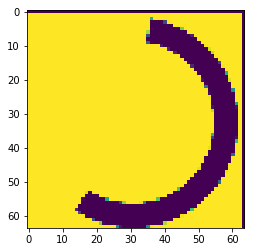

In [153]:
img = next(dataiter).numpy()[0,0,:,:]
plt.imshow(img)